In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, field
import datetime
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [7]:

class SentimentEngine:
    """
    Modes:
      - 'transformer' -> uses nlptown/bert-base-multilingual-uncased-sentiment (1-5 stars)
      - 'vader'       -> uses VADER (pos/neg/neu + compound)
    """
    def __init__(self, mode: str = "transformer"):
        self.mode = mode
        if self.mode == "transformer":
            
            self.model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
        else:
            self.model = SentimentIntensityAnalyzer()

    def analyze(self, text: str) -> Dict:
        text = text.strip()
        if not text:
            return {"label": "Neutral", "detail": {}, "score": 0.0}
        if self.mode == "transformer":
            r = self.model(text)[0]               
            label_raw = r.get("label", "")
            score = r.get("score", 0.0)
            
            try:
                stars = int(label_raw.split()[0])
            except Exception:
                stars = 3
            if stars >= 4:
                label = "Positive"
            elif stars == 3:
                label = "Neutral"
            else:
                label = "Negative"
            return {"label": label, "detail": {"stars": stars, "raw_label": label_raw, "score": score}, "score": stars}
        else:
            r = self.model.polarity_scores(text)  
            comp = r["compound"]
            if comp >= 0.05:
                label = "Positive"
            elif comp <= -0.05:
                label = "Negative"
            else:
                label = "Neutral"
            return {"label": label, "detail": r, "score": comp}


class IssueClassifier:
    def __init__(self, use_zero_shot: bool = True):
        self.topics = ["Food Quality", "Service", "Ambience", "Pricing", "Other"]
        self.use_zero_shot = use_zero_shot
        if self.use_zero_shot:
            self.zs = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
        
        self.keywords = {
            "Food Quality": ["food","taste","cold","hot","fresh","stale","flavour","flavor","spicy","bland"],
            "Service": ["waiter","staff","service","slow","rude","attentive","server","host"],
            "Ambience": ["noise","music","ambience","decor","clean","dirty","atmosphere","smell"],
            "Pricing": ["price","expensive","cheap","cost","bill","worth"]
        }

    def classify(self, text: str) -> Tuple[str, Dict]:
        text_low = text.lower()
        if self.use_zero_shot:
            try:
                res = self.zs(text, self.topics)
                top = res["labels"][0]
                
                if res["scores"][0] < 0.3:
                    raise Exception("low confidence")
                return top, {"method": "zero-shot", "scores": res}
            except Exception:
                
                pass
        
        for topic, kws in self.keywords.items():
            if any(k in text_low for k in kws):
                return topic, {"method": "keyword"}
        return "Other", {"method": "keyword"}


@dataclass
class MessageRecord:
    timestamp: str
    message: str
    sentiment_label: str
    sentiment_detail: Dict
    issue: str
    issue_detail: Dict

@dataclass
class ConversationBot:
    sentiment_engine: SentimentEngine
    issue_classifier: IssueClassifier
    history: List[MessageRecord] = field(default_factory=list)

    def handle_message(self, message: str) -> Dict:
        t = datetime.datetime.now().isoformat(timespec="seconds")
        sent = self.sentiment_engine.analyze(message)
        issue, issue_info = self.issue_classifier.classify(message)
        rec = MessageRecord(
            timestamp=t,
            message=message,
            sentiment_label=sent["label"],
            sentiment_detail=sent["detail"],
            issue=issue,
            issue_detail=issue_info
        )
        self.history.append(rec)
        
        reply = self._generate_reply(rec)
        return {"reply": reply, "record": rec}

    def _generate_reply(self, rec: MessageRecord) -> str:
        label = rec.sentiment_label
        issue = rec.issue
        if label == "Positive":
            return f"Thank you — we're glad you enjoyed the {issue.lower()}! 🍽️"
        elif label == "Negative":
            return (f"We're very sorry to hear about your experience with {issue.lower()}. "
                    "Could you tell us a little more? We'll address it right away. 🙏")
        else:
            return f"Thanks for the feedback about {issue.lower()}. We appreciate your honesty."

    def export_dataframe(self) -> pd.DataFrame:
        rows = []
        for r in self.history:
            rows.append({
                "timestamp": r.timestamp,
                "message": r.message,
                "sentiment_label": r.sentiment_label,
                "sentiment_detail": r.sentiment_detail,
                "issue": r.issue,
                "issue_detail": r.issue_detail
            })
        return pd.DataFrame(rows)


class TrendAnalyzer:
    def summarize_conversation(self, history: List[MessageRecord]) -> Dict:
        if not history:
            return {"positive":0,"negative":0,"neutral":0,"overall":"No conversation"}
        pos = sum(1 for h in history if h.sentiment_label == "Positive")
        neg = sum(1 for h in history if h.sentiment_label == "Negative")
        neu = sum(1 for h in history if h.sentiment_label == "Neutral")
        total = pos + neg + neu
        if pos > neg and pos > neu:
            overall = "Overall Positive"
        elif neg > pos and neg > neu:
            overall = "Overall Negative"
        else:
            overall = "Neutral / Mixed"
        return {"positive":pos,"negative":neg,"neutral":neu,"total":total,"overall":overall}

    def show_statement_level(self, history: List[MessageRecord], show_details: bool = False):
        # prints each message with sentiment
        for i, h in enumerate(history, 1):
            print(f"{i:02d}. [{h.timestamp}] {h.message}")
            print(f"    → Sentiment: {h.sentiment_label} | Issue: {h.issue}")
            if show_details:
                print(f"      details: {h.sentiment_detail} | issue_info: {h.issue_detail}")
            print()

    def plot_sentiment_trend(self, history: List[MessageRecord]):
        if not history:
            print("No data to plot.")
            return
        mapping = {"Negative": -1, "Neutral": 0, "Positive": 1}
        vals = [mapping.get(h.sentiment_label, 0) for h in history]
        plt.figure(figsize=(10,4))
        plt.plot(range(1, len(vals)+1), vals, marker='o')
        plt.ylim(-1.5, 1.5)
        plt.yticks([-1,0,1], ["Negative","Neutral","Positive"])
        plt.xlabel("Message #")
        plt.title("Conversation-level Sentiment Trend")
        plt.grid(True)
        plt.show()


In [8]:

sent_engine = SentimentEngine(mode="transformer")   
issue_cls = IssueClassifier(use_zero_shot=True)     
bot = ConversationBot(sent_engine, issue_cls)
analyzer = TrendAnalyzer()

print("Restaurant Feedback Chatbot — type 'end' to finish.\n")
while True:
    text = input("Customer: ")
    if text.strip().lower() in ("end","exit","quit"):
        break
    out = bot.handle_message(text)
    
    rec = out["record"]
    print(f"Bot Reply: {out['reply']}")
    print(f" → [Sentiment: {rec.sentiment_label}]  [Issue: {rec.issue}]  [Timestamp: {rec.timestamp}]\n")


Device set to use cpu
Device set to use cpu


Restaurant Feedback Chatbot — type 'end' to finish.



Customer:  hello


Bot Reply: Thank you — we're glad you enjoyed the other! 🍽️
 → [Sentiment: Positive]  [Issue: Other]  [Timestamp: 2025-12-02T13:09:30]



Customer:  food is too bad


Bot Reply: We're very sorry to hear about your experience with food quality. Could you tell us a little more? We'll address it right away. 🙏
 → [Sentiment: Negative]  [Issue: Food Quality]  [Timestamp: 2025-12-02T13:09:49]



Customer:  waiter spill drink on my expensive coat


Bot Reply: Thank you — we're glad you enjoyed the service! 🍽️
 → [Sentiment: Positive]  [Issue: Service]  [Timestamp: 2025-12-02T13:10:12]



Customer:  end


=== Conversation-Level Sentiment Analysis ===
Total messages: 3
Positive: 2  Negative: 1  Neutral: 0
Overall emotional direction: Overall Positive

=== Statement-Level Sentiment Analysis (all messages) ===

01. [2025-12-02T13:09:30] hello
    → Sentiment: Positive | Issue: Other

02. [2025-12-02T13:09:49] food is too bad
    → Sentiment: Negative | Issue: Food Quality

03. [2025-12-02T13:10:12] waiter spill drink on my expensive coat
    → Sentiment: Positive | Issue: Service



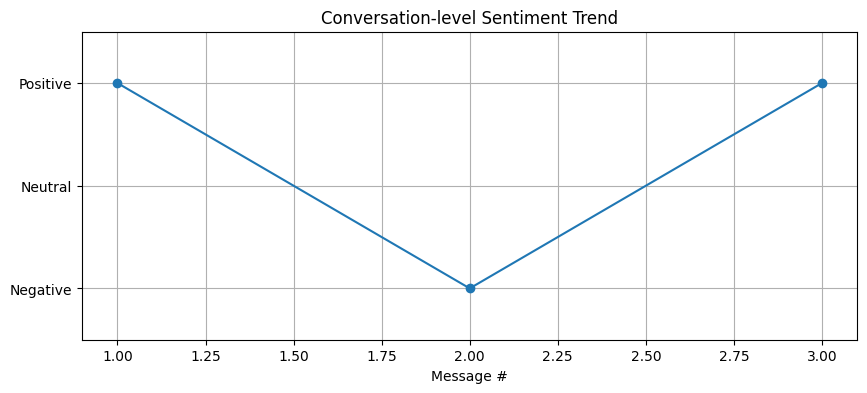


Saved conversation + analysis to: restaurant_feedback_realistic.xlsx


In [9]:

summary = analyzer.summarize_conversation(bot.history)
print("=== Conversation-Level Sentiment Analysis ===")
print(f"Total messages: {summary.get('total', len(bot.history))}")
print(f"Positive: {summary['positive']}  Negative: {summary['negative']}  Neutral: {summary['neutral']}")
print(f"Overall emotional direction: {summary['overall']}\n")


print("=== Statement-Level Sentiment Analysis (all messages) ===\n")
analyzer.show_statement_level(bot.history, show_details=False)


analyzer.plot_sentiment_trend(bot.history)


df = bot.export_dataframe()
filename = "restaurant_feedback_realistic.xlsx"
df.to_excel(filename, index=False)
print(f"\nSaved conversation + analysis to: {filename}")
